# This notebook calculates the EMC ratio of RGE data
## The data will be corrected using EXTERNALS
## It will be compared to the results found in arXiv: 2402.17147

In [1]:
import uproot as ur
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import mplhep as hep
hep.style.use("CMS")
hep.style.use(hep.style.CMS)

### Data file you want to analyze

In [2]:
data_directory = "/home/ryan/clas_analysis/data/"
file_name = "ntuples_dc_020029-020033.root"
with ur.open("%s:data"%(data_directory+file_name)) as events:
    branches = events.arrays()

### Only selecting electrons and those that satisfy DIS cuts

In [3]:
electron_PID_cut = (branches["pid"]==11) & (branches["trigger_status"]==1)
Q2_cut_value = 1.5
W_cut_value = 1.8
W2_cut_value = W_cut_value * W_cut_value
y_cut_value = .85
Q2_cut = branches["Q2"] > Q2_cut_value
W2_cut = branches["W2"] > W2_cut_value
y_cut = branches["y_bjorken"] < y_cut_value
DIS_cuts = Q2_cut & W2_cut & y_cut
electron_DIS_cut = electron_PID_cut & DIS_cuts

### Select the solid target you're considering

In [4]:
solid_target = "C"
solid_A = {"Pb":208, "C":12}
solid_Z = {"Pb":82, "C":6}
solid_N = {"Pb":solid_A["Pb"]-solid_Z["Pb"],
           "C":solid_A["C"]-solid_Z["C"]}

### Title used in all the plots

In [5]:
plot_title = "Runs 20029-20033: LD2 + {solid}\n$Q^2 > {Q2cut}~GeV^2$, $W > {Wcut}~GeV, y < {ycut}$".format(
    solid=solid_target,
    Q2cut = Q2_cut_value,
    Wcut=np.sqrt(W2_cut_value),
    ycut = y_cut_value)

### Calculating the areal densities of each target 
### Will use ratio of areal densities of solid to deuterium as a scaling factor in EMC ratio

In [6]:
targets_density = {"Pb":(10.910 + 10.402) / 2,
                   "C":(1.688 + 1.712) /2,
                   "D":(.169 + .163) / 2} # Average density in g/cm^3. Taken from data table.
targets_thickness = {"Pb":.0143,
                     "C":0.151,
                     "D":2.0} # Target thickness in cm
targets_areal_density = {"Pb":targets_density["Pb"]*targets_thickness["Pb"],
                         "C":targets_density["C"]*targets_thickness["C"],
                         "D":targets_density["D"]*targets_thickness["D"]} # Average areal density in g/cm^2
areal_density_ratio = targets_areal_density["D"]/targets_areal_density[solid_target]
print("Areal density ratio of {target}/Deuterium:".format(target=solid_target), areal_density_ratio)

Areal density ratio of C/Deuterium: 1.293338527463966


### Using the vertex z position to separate deuterium & solid targets
### z positions obtained via double Gaussian fit

In [7]:
from scipy.optimize import curve_fit
def double_gaussian(x, amp1, mean1, sigma_squared1, amp2, mean2, sigma_squared2):
    return amp1 * np.exp( -(x - mean1)**2 / (2*sigma_squared1) ) + \
           amp2 * np.exp( -(x - mean2)**2 / (2*sigma_squared2) )

Text(0.5, 1.0, 'Runs 20029-20033: LD2 + C\n$Q^2 > 1.5~GeV^2$, $W > 1.8~GeV, y < 0.85$')

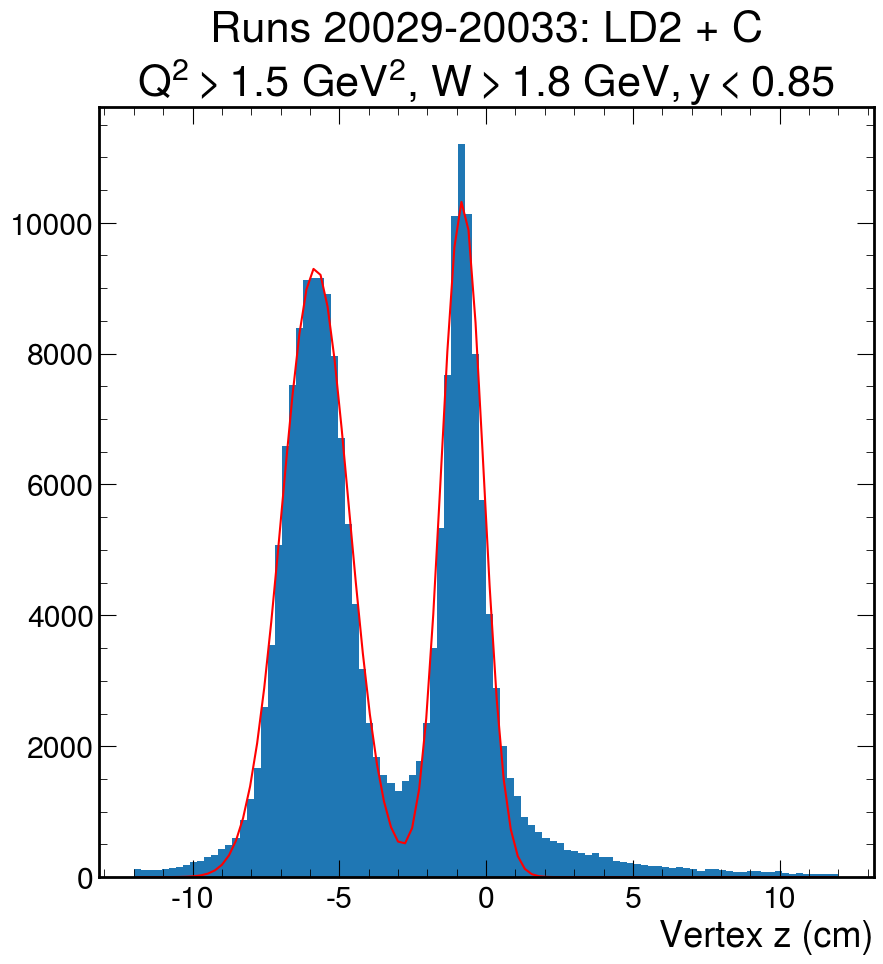

In [8]:
electron_vertex_z = branches["v_z"][electron_DIS_cut]

# Binning chose arbitrarily. Might have to adjust to get a good fit.
vertex_z_counts, vertex_z_bins, _ = plt.hist(electron_vertex_z, bins = 100, range=(-12, 12))

vertex_z_bin_centers = (vertex_z_bins[:-1] + vertex_z_bins[1:])/2
mean_z_guess = ak.mean(electron_vertex_z)
std_z_guess = ak.std(electron_vertex_z)

z_fit_parameters, z_fit_covariance = curve_fit(double_gaussian,
                                               vertex_z_bin_centers,
                                               vertex_z_counts, 
                                               p0=(100, mean_z_guess, std_z_guess**2, 100, mean_z_guess, std_z_guess**2))

y_fit = double_gaussian(vertex_z_bin_centers, *z_fit_parameters)
plt.plot(vertex_z_bin_centers, y_fit, color='r')

plt.xlabel("Vertex z (cm)")
plt.title(plot_title)

### Making our vertex cut

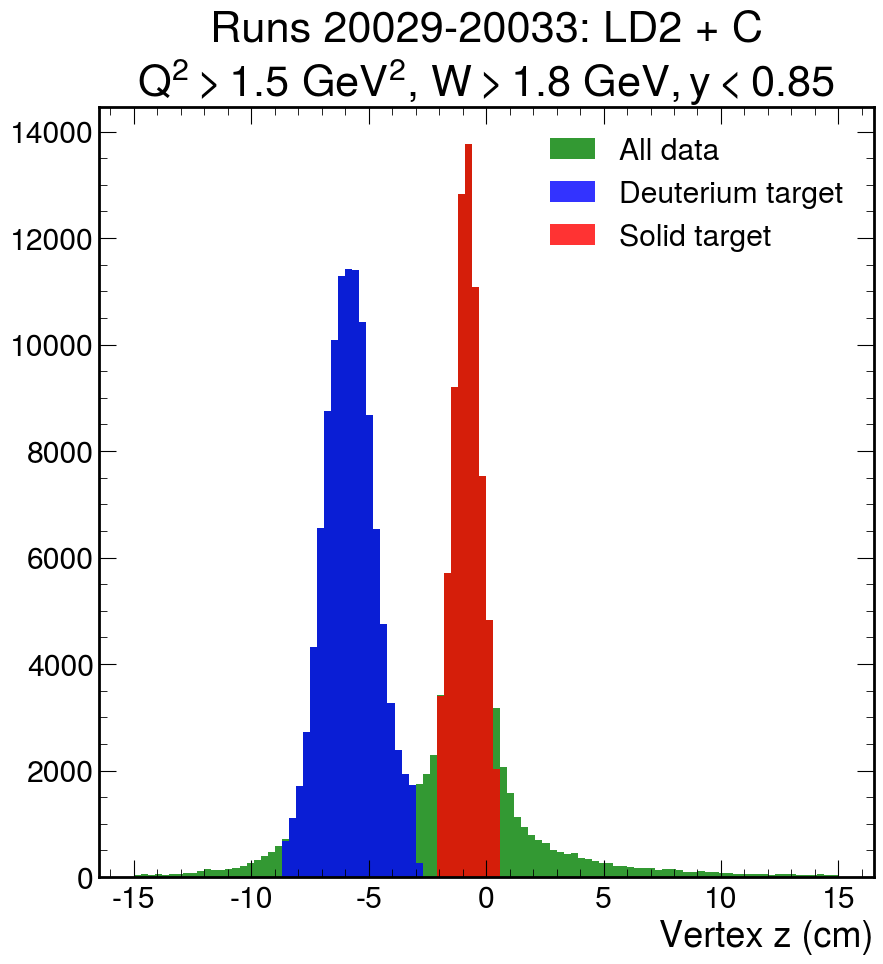

In [27]:
# Deuterium should have the more negative vertex z position
# So, say the minimum z mean from fit belongs to deutrium

deuterium_z_mean = min(z_fit_parameters[1], z_fit_parameters[4])
if deuterium_z_mean == z_fit_parameters[1]:
    deuterium_z_sigma = z_fit_parameters[2]
    solid_z_mean, solid_z_sigma = z_fit_parameters[4], z_fit_parameters[5]
elif deuterium_z_mean == z_fit_parameters[4]:
    deuterium_z_sigma = z_fit_parameters[5]
    solid_z_mean, solid_z_sigma = z_fit_parameters[1], z_fit_parameters[2]

# 2 sigma cut was chosen arbitrarily. Just a first attempt that looks OK.
deuterium_cut = (electron_vertex_z > (deuterium_z_mean - 2.2 * deuterium_z_sigma) ) &\
                (electron_vertex_z < (deuterium_z_mean + 2.2 * deuterium_z_sigma) )
solid_cut     = (electron_vertex_z > (solid_z_mean - 2.5 * solid_z_sigma) ) &\
                (electron_vertex_z < (solid_z_mean + 2.5 * solid_z_sigma) )

plt.hist(electron_vertex_z,
         bins = 100,
         range=(-15, 15),
         color='g',
         label="All data",
         alpha=.8)
plt.hist(electron_vertex_z[deuterium_cut],
         bins = 100,
         range=(-15, 15),
         color='b',
         label="Deuterium target",
         alpha=.8)
plt.hist(electron_vertex_z[solid_cut],
         bins = 100,
         range=(-15, 15),
         color='r',
         label="Solid target",
         alpha=.8)

plt.xlabel("Vertex z (cm)")
plt.title(plot_title)
plt.legend()
plt.show()

# Calculating the EMC ratio 

In [28]:
electron_x = branches["x_bjorken"][electron_DIS_cut]
electron_Q2 = branches["Q2"][electron_DIS_cut]
deuterium_x = electron_x[deuterium_cut]
solid_x = electron_x[solid_cut]
deuterium_Q2 = electron_Q2[deuterium_cut]
solid_Q2 = electron_Q2[solid_cut]

### Data that we will be comparing to
### From arXiv: 2402.17147

In [29]:
eg2_clas_x = [.2200, .247, .260, .273, .287, .300, .313, .327, .340, .353,\
              .367, .380, .393, .407, .420, .433, .447, .460, .473, .487,.500,\
              .513, .527, .540, .553, .580]
eg2_clas_Pb_EMC = [1.0366, 1.0281, 1.0201, 1.0176, 1.0141, 1.0093, 1.0103,\
                   1.0148, 1.0126, 1.0017, 0.9962, 0.9924, 0.9817, 0.9967,\
                   0.9805, 0.9626, 0.9640, 0.9481, 0.9562, 0.9428, 0.9325,\
                   0.9356, 0.9194, 0.9182, 0.8915, 0.8978]
eg2_clas_Pb_EMC_error = [.0510, .0095, .0095, .0095, .0095, .0095, .0095,\
                        .0095, .0095, .0095, .0095, .0086, .0086, .0095,\
                        .0086, .0086, .0086, .0085, .0085, .0085, .0085,\
                        .0094, .0093, .0094, .0180, .0426]

eg2_clas_C_EMC = [1.0276, 1.0111, 1.0036, 1.0020, .9956, .9939, .9995, 1.0033,\
                  1.0020, .9923, .9887, .9860, .9776, .9933, .9829, .9625,\
                  .9612, .9547, .9614, .9460, .9456, .9562, .9457, .9422,\
                  .9186, .9427]
eg2_clas_C_EMC_error = [.0490, .0094, .0094, .0094, .0094, .0094, .0094,\
                        .0094, .0094, .0094, .0094, .0094, .0094, .0094,\
                        .0094, .0094, .0094, .0093, .0094, .0094, .0093,\
                        .0102, .0102, .0102, .0198, .0471]
eg2_clas_EMC = {"Pb":eg2_clas_Pb_EMC, "C":eg2_clas_C_EMC}
eg2_clas_EMC_error = {"Pb":eg2_clas_Pb_EMC_error, "C":eg2_clas_C_EMC_error}

### Making our bin edges match those from above paper

In [30]:
x_bin_edges = []
for i, entry in enumerate(eg2_clas_x[1:-1]):
    if i == 0:
        x_bin_edges.append(entry - .0135/2)
    x_bin_edges.append(entry + .0135/2)
x_bin_edges.insert(0, eg2_clas_x[0]-(x_bin_edges[0]-eg2_clas_x[0]) )
x_bin_edges.append(eg2_clas_x[-1] + (eg2_clas_x[-1]-x_bin_edges[-1]))

new_bin_width = (x_bin_edges[-1]-x_bin_edges[-2])
x_bin_edges = np.asarray(x_bin_edges)
x_bin_edges = np.append(x_bin_edges, x_bin_edges[-1] + np.arange(1,10)*new_bin_width)

### Geting counts within x bins for each target

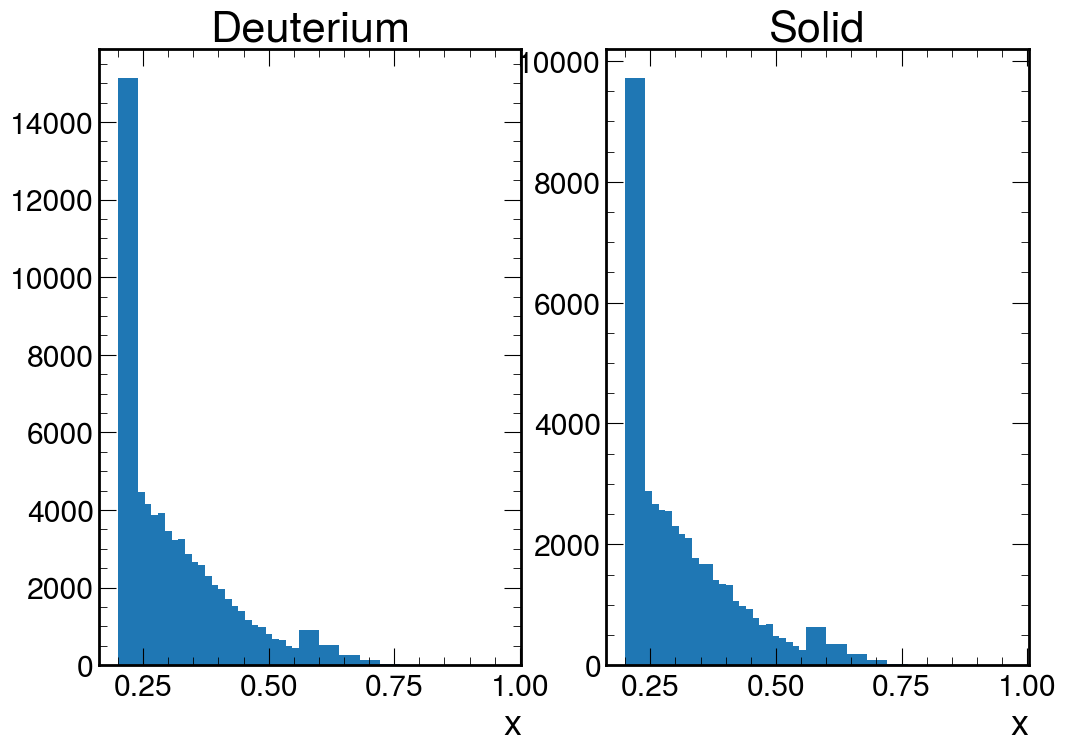

In [31]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,8))
deuterium_x_counts, deuterium_x_bins, _ = ax1.hist(deuterium_x, bins = x_bin_edges)
ax1.set_xlabel("x")
ax1.set_title("Deuterium")

deuterium_x_bin_centers = (deuterium_x_bins[:-1] + deuterium_x_bins[1:])/2
deuterium_x_counts_errors = np.sqrt(deuterium_x_counts)

solid_x_counts, solid_x_bins, _ = ax2.hist(solid_x, bins = x_bin_edges)
ax2.set_xlabel("x")
ax2.set_title("Solid")

solid_x_bin_centers = (solid_x_bins[:-1] + solid_x_bins[1:])/2
solid_x_counts_errors = np.sqrt(solid_x_counts)

## Plotting the initial EMC ratio

In [32]:
# Utility functions that we can use during EMC analysis

# Linear fit function for EMC region
def linear_fit(x, slope, yintercept):
    return slope*x + yintercept

# Propagate the errors when dividing two numbers
def DivideWithErrors(numerator, numerator_error, denominator, denominator_error):
    if denominator == 0:
        divided = np.nan
        error = np.nan
    else:
        divided = numerator/denominator
        error = divided * np.sqrt((numerator_error/numerator)**2 + (denominator_error/denominator)**2)
    return (divided, error)

# Propagating the errors when dividing two arrays
def DivideArrayWithErrors(numerator_array, numerator_error_array, denominator_array, denominator_error_array):
    divided_list = []
    divided_error_list = []
    for numerator, numerator_error, denominator, denominator_error in zip(numerator_array, numerator_error_array, denominator_array, denominator_error_array):
        divided_tuple = DivideWithErrors(numerator, numerator_error, denominator, denominator_error)
        divided_list.append(divided_tuple[0])
        divided_error_list.append(divided_tuple[1])
    divided_list = np.asarray(divided_list)
    divided_error_list = np.asarray(divided_error_list)
    return divided_list, divided_error_list

Slope is -0.034 \pm 0.082 in EMC region.


/tmp/ipykernel_748113/1471708894.py:14: RuntimeWarning: invalid value encountered in scalar divide
  error = divided * np.sqrt((numerator_error/numerator)**2 + (denominator_error/denominator)**2)


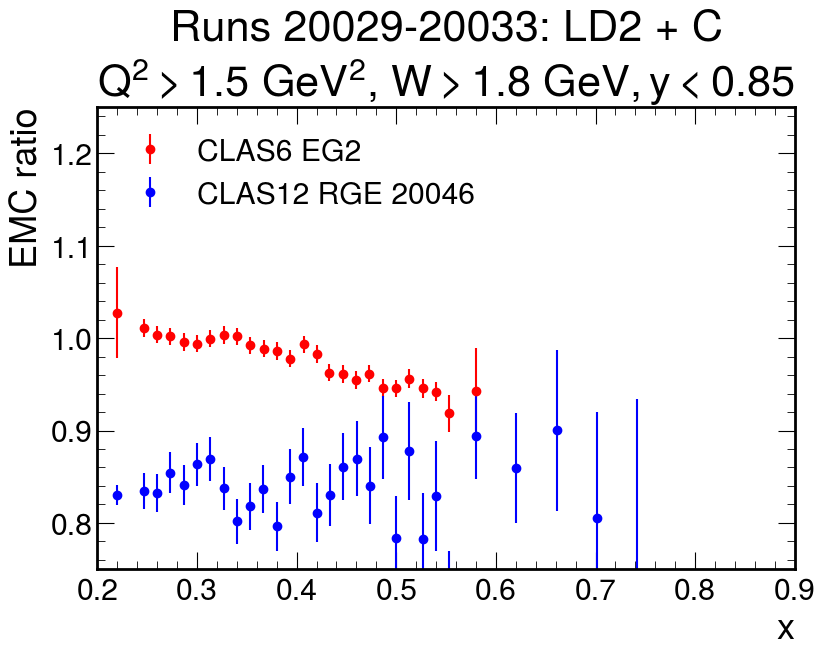

In [35]:
fig = plt.figure(figsize=(9,6))
EMC_ratio_x, EMC_ratio_x_errors = DivideArrayWithErrors(solid_x_counts,
                                                        solid_x_counts_errors,
                                                        deuterium_x_counts,
                                                        deuterium_x_counts_errors)

# Scaling EMC ratio by areal density ratio
EMC_ratio_x *= areal_density_ratio
EMC_ratio_x_errors *= areal_density_ratio

# Remove any x bins that resulted in division by zero (i.e. zero deuterium counts)
nan_mask = ~np.isnan(EMC_ratio_x)



plt.errorbar(eg2_clas_x,
             eg2_clas_EMC[solid_target],
             yerr=eg2_clas_EMC_error[solid_target],
             linestyle='none',
             fmt ='o',
             label="CLAS6 EG2",
             color='red')

plt.errorbar(solid_x_bin_centers[nan_mask],
             EMC_ratio_x[nan_mask],
             yerr=EMC_ratio_x_errors[nan_mask],
             linestyle='none',
             fmt ='o',
             label="CLAS12 RGE 20046",
             color='blue')

plt.xlabel("x")
plt.ylabel("EMC ratio")

# Fitting EMC region to linear function
EMC_x_region_mask = (solid_x_bin_centers > .25) & (solid_x_bin_centers < .65)
EMC_x_region_x = solid_x_bin_centers[EMC_x_region_mask]
EMC_x_region_y = EMC_ratio_x[EMC_x_region_mask]
slope_guess = (EMC_x_region_y[-1]-EMC_x_region_y[0])/(EMC_x_region_x[-1]-EMC_x_region_x[0])
y_intercept_guess = EMC_x_region_y[0]

fit_parameters, fit_covariance = curve_fit(linear_fit,
                                           EMC_x_region_x,
                                           EMC_x_region_y,
                                           p0=(slope_guess, y_intercept_guess))
errors = np.sqrt(np.diag(fit_covariance))
y_fit = linear_fit(EMC_x_region_x, *fit_parameters)
print("Slope is {slope} \pm {error} in EMC region.".format(slope = round(fit_parameters[0], 3), error = round(errors[0], 3) ))
plt.ylim(.75, 1.25)
plt.xlim(.2, .9)
plt.title(plot_title)
plt.legend(loc='upper left')
plt.show()

## Applying corrections to the data
### Need to calculate the centroids (center of mass) of Q2, x bins

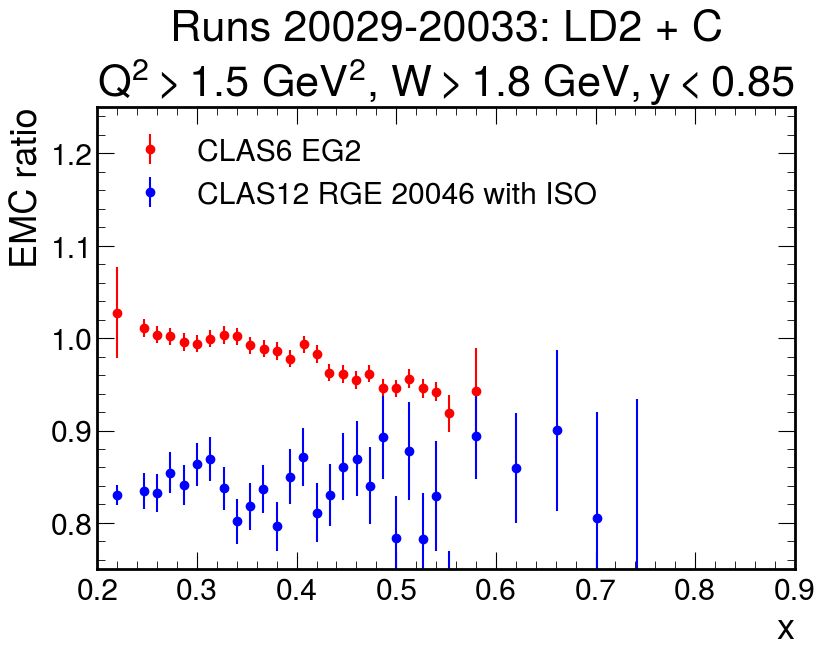

In [36]:
# isoscalar correction
sigma_ratio = 1 - 0.8 *solid_x_bin_centers[nan_mask] # SLAC parameteriziation
isoscalar_corrections = (solid_A[solid_target]/2 * (1+sigma_ratio))/(solid_Z[solid_target] + solid_Z[solid_target]*sigma_ratio)
fig = plt.figure(figsize=(9,6))

isoscalar_EMC = EMC_ratio_x[nan_mask]*isoscalar_corrections

plt.errorbar(eg2_clas_x,
             eg2_clas_EMC[solid_target],
             yerr=eg2_clas_EMC_error[solid_target],
             linestyle='none',
             fmt ='o',
             label="CLAS6 EG2",
             color='red')

plt.errorbar(solid_x_bin_centers[nan_mask],
             isoscalar_EMC,
             yerr=EMC_ratio_x_errors[nan_mask]*isoscalar_corrections,
             linestyle='none',
             fmt ='o',
             label="CLAS12 RGE 20046 with ISO",
             color='blue')

plt.xlabel("x")
plt.ylabel("EMC ratio")
plt.ylim(.75, 1.25)
plt.xlim(.2, .9)
plt.title(plot_title)
plt.legend(loc='upper left')
plt.show()


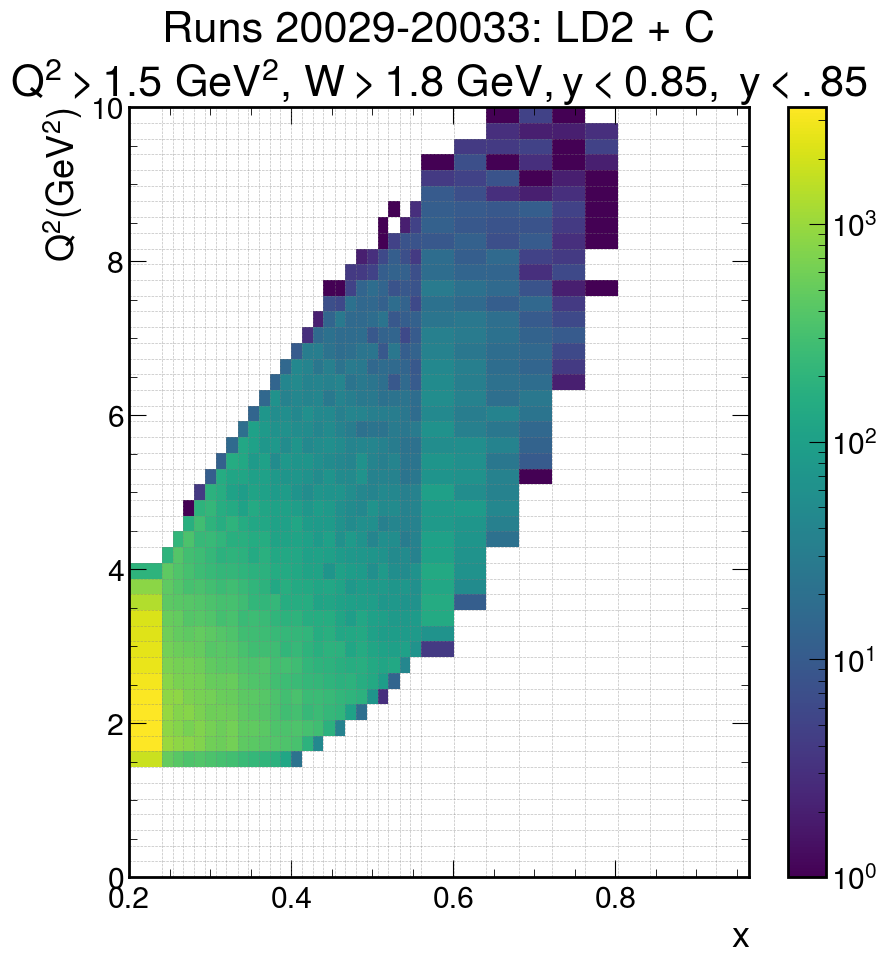

In [17]:
# Not doing anything, just showing the histogram we'll be using for calculating the centroids
import matplotlib.colors as mcolors

Q2_bin_edges = np.linspace(0, 10, 50)
plt.hist2d(np.array(electron_x),
           np.array(electron_Q2),
           bins=(x_bin_edges, Q2_bin_edges),
           norm=mcolors.LogNorm())
plt.xlabel("x")
plt.ylabel("$Q^2 (GeV^2)$")
plt.colorbar()
plt.title(plot_title+"$,~y<.85$")
for bin_edge in Q2_bin_edges:
    plt.axhline(y = bin_edge, color = 'gray', linestyle='dashed', alpha = .5, linewidth = 0.5)
for bin_edge in x_bin_edges:
    plt.axvline(x = bin_edge, color = 'gray', linestyle='dashed', alpha = .5, linewidth = 0.5)

### Calculating the centroids of each bin

In [18]:
x_centroids = []
Q2_centroids = []
for i, x_edge in enumerate(x_bin_edges):
    if i == len(x_bin_edges)-1:
        break
    x_bin_low, x_bin_high = x_edge, x_bin_edges[i+1]
    for j, Q2_edge in enumerate(Q2_bin_edges):
        if j == len(Q2_bin_edges)-1:
            break
        Q2_bin_low, Q2_bin_high = Q2_edge, Q2_bin_edges[j+1]
        bin_mask = (electron_x < x_bin_high) & (electron_x > x_bin_low) & (electron_Q2 < Q2_bin_high) & (electron_Q2 > Q2_bin_low)
        x_in_bin = electron_x[bin_mask]
        Q2_in_bin = electron_Q2[bin_mask]
        if len(x_in_bin) == 0 or len(Q2_in_bin) == 0:
            continue
        x_center = np.mean(electron_x[bin_mask])
        x_centroids.append(x_center)
        y_center = np.mean(electron_Q2[bin_mask])
        Q2_centroids.append(y_center)

### Showing our centroids overlayed on our Q2 vs x histogram

Text(0.5, 1.0, 'Runs 20029-20033: LD2 + C\n$Q^2 > 1.5~GeV^2$, $W > 1.8~GeV, y < 0.85$\n$y<.85$')

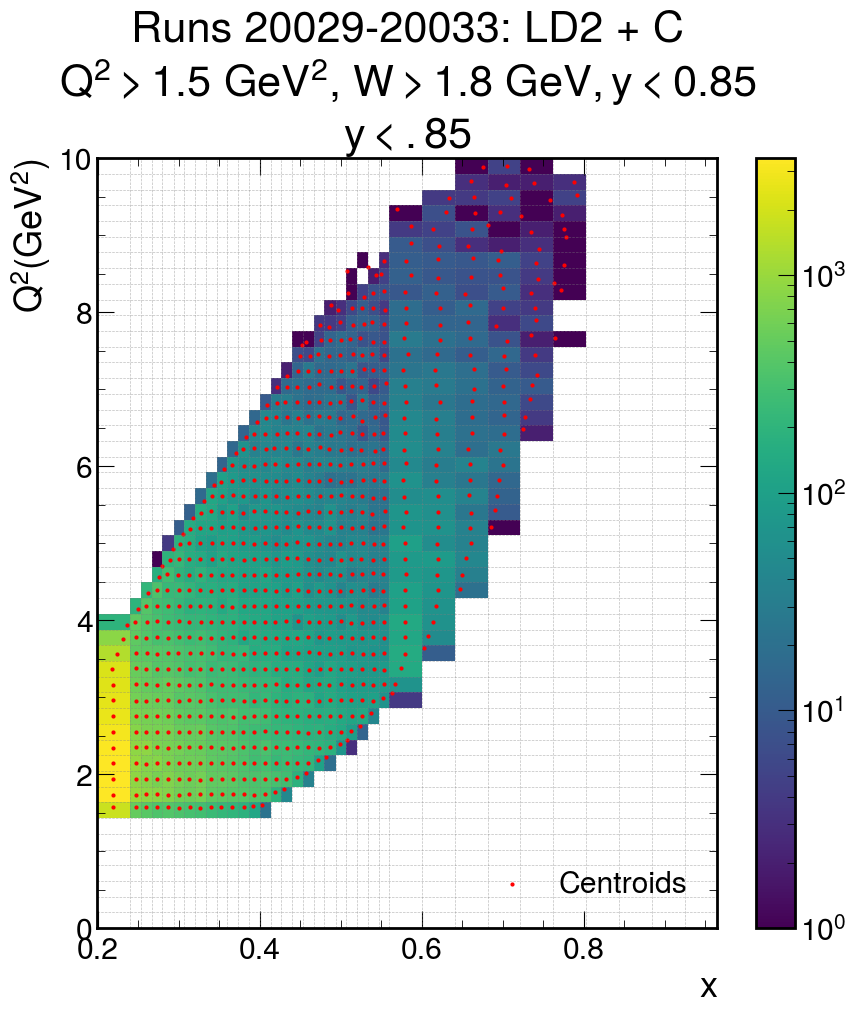

In [19]:
plt.hist2d(np.array(electron_x),
           np.array(electron_Q2),
           bins=(x_bin_edges, Q2_bin_edges),
           norm=mcolors.LogNorm())
plt.xlabel("x")
plt.ylabel("$Q^2 (GeV^2)$")
plt.colorbar()
plt.scatter(x_centroids,
            Q2_centroids,
            color = 'r',
            label="Centroids",
            s = 4)

# Drawing the bin edges
for bin_edge in Q2_bin_edges:
    plt.axhline(y = bin_edge, color = 'gray', linestyle='dashed', alpha = .5, linewidth = 0.5)
for bin_edge in x_bin_edges:
    plt.axvline(x = bin_edge, color = 'gray', linestyle='dashed', alpha = .5, linewidth = 0.5)
plt.legend(loc = 'lower right')
plt.title(plot_title+"\n$y<.85$")